# Clustering for gevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class', 'gev_1FGL_Name', 'gev_CLASS1', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/gevsimbad_normalized.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,0.016565,0.318116,0.116714,0.194982,0.353622,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
1,0.000004,0.000080,0.000017,0.000040,0.000080,0.0,0.000087,0.000036,0.000081,0.000102,...,0.0,0.000044,0.000123,0.000141,0.0,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
2,0.014351,0.087269,0.096480,0.058873,0.082640,0.0,0.000042,0.000023,0.000179,0.000817,...,0.0,0.000000,0.000000,0.000000,0.0,b'UCAC2 5051621',Be,b' ',b'spp ',0
3,0.054146,0.123705,0.442960,0.121311,0.188794,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
4,0.046428,0.232212,0.271011,0.145261,0.304359,0.0,0.000000,0.000028,0.000026,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

* ### earth mover's distance

In [29]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)

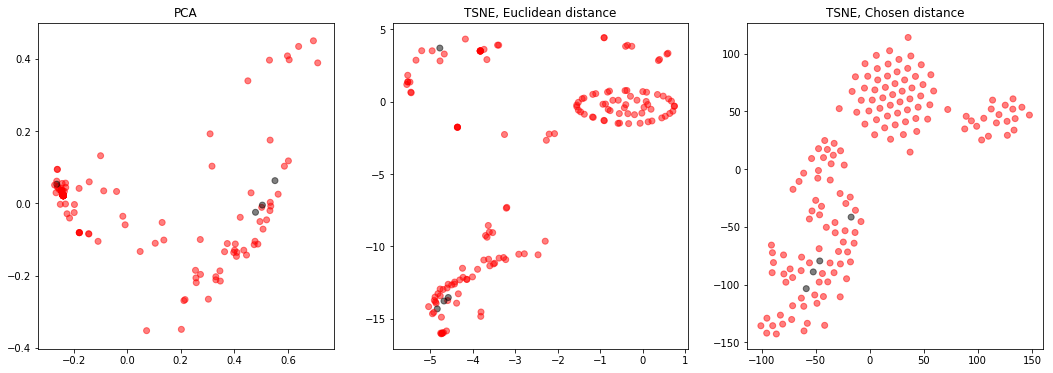

In [30]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=300)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=500)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [31]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.08251635788311906)

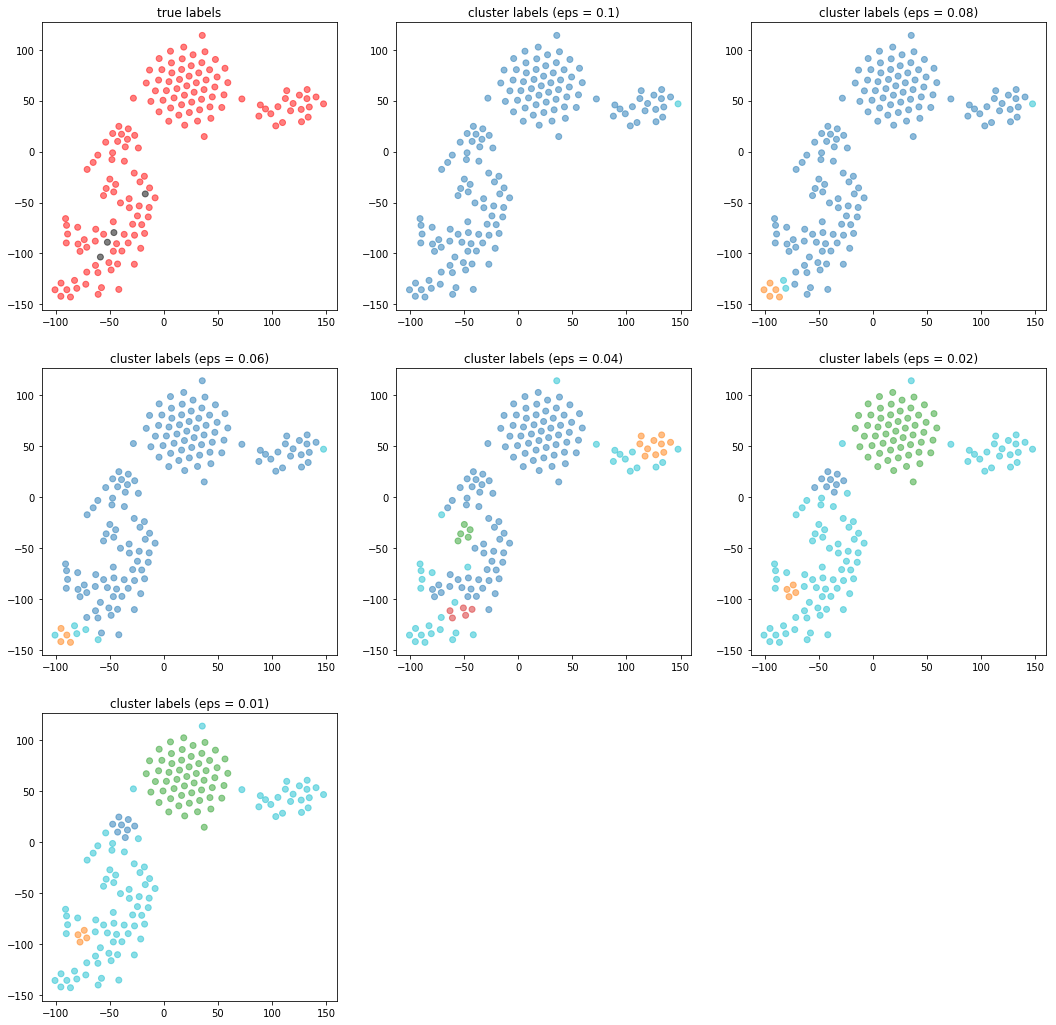

In [32]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=500)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.01 * i for i in range(10, 0, -2)] + [0.01]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [33]:
eps = 0.04

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
6,b'LS I +56 58',B,b' ',b' ',0
7,b'PG 1101+529',B,b' ',b' ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
12,b'MAC 1-490',B,b' ',b'bcu ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0


1 cluster (tab:orange)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
35,b'GCIRS 1W',B,b' ',b' ',0


2 cluster (tab:green)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
52,b'GCIRS 8',O,b'1FGL J1745.6-2900c',b'spp ',0


3 cluster (tab:red)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
5,b'LS VI -04 15',B,b' ',b' ',0
43,b'HD 295998',B,b' ',b' ',0
68,b'CPD-59 2596',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0
72,b'CD-59 3472',B0Ve,b' ',b' ',0
84,b'CPD-59 2700',B0Ve,b' ',b' ',0


4 cluster (tab:purple)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
9,b'HD 306182',B,b' ',b'spp ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
61,b'HD 306179',B0Ve,b' ',b'spp ',0
67,b'CPD-59 2674',B0Ve,b' ',b' ',0
76,b'LS I +62 58',B0Ve,b' ',b' ',0
82,b'HD 306181',B0Ve,b' ',b'spp ',0
83,b'UCAC4 146-087591',B0Ve,b'1FGL J1134.8-6055 ',b'PSR ',0
86,b'V* EN Car',B0Ve,b' ',b'spp ',0


5 cluster (tab:brown)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
64,b'HD 192039',B0Ve,b' ',b' ',0


6 cluster (tab:pink)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
19,b'LS IV -14 70',B,b' ',b' ',0
31,b'LS II +38 34',B,b' ',b'bcu ',0
62,b'HD 298377',B0Ve,b' ',b' ',0
65,b'Cl Trumpler 14 4',B0Ve,b' ',b' ',0
71,b'CPD-58 2649',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0


7 cluster (tab:gray)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0


8 cluster (tab:olive)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
48,b'CPD-58 2614',O,b' ',b' ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0


9 cluster (tab:cyan)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
55,b'TYC 3156-998-1',O,b' ',b'SFR ',0
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0
92,b'HD 330587',B0Ve,b' ',b' ',0
150,b'3XMM J183327.7-103524',B0Ve,b'1FGL J1833.5-1034 ',b'PSR ',0


-1 cluster (tab:cyan)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
27,b'EC 20443-3134',B,b' ',b' ',0
41,b'HD 92406',B,b' ',b' ',0
46,b'PG 0042+211',O,b'1FGL J0045.3+2127 ',b'bll ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
63,b'Cl Trumpler 16 245',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0
69,b'[LCL2005b] G305.3+0.2 A2',B0Ve,b' ',b' ',0
70,b'CPD-59 3179',B0Ve,b' ',b'spp ',0
89,b'2MASS J02252738+6203432',B0Ve,b' ',b' ',0


* ### euclidean distance

In [23]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

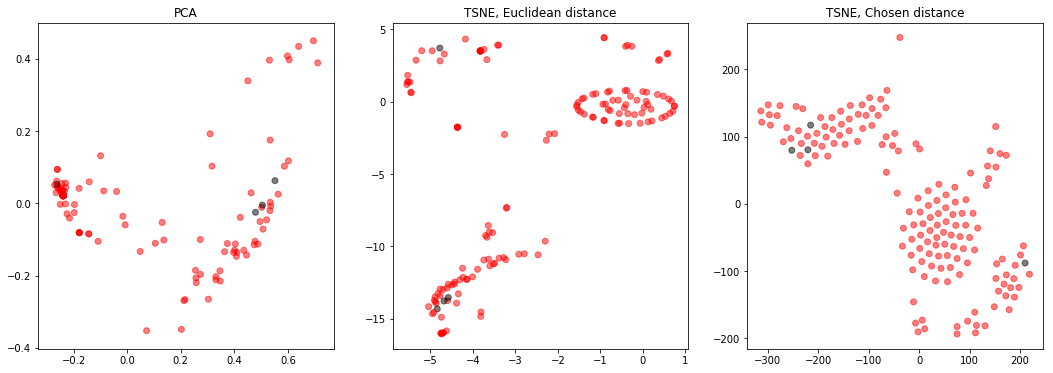

In [24]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=300, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=600)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [25]:
spectra_distances.min(), spectra_distances.max()

(0.0, 1.2338869252077214)

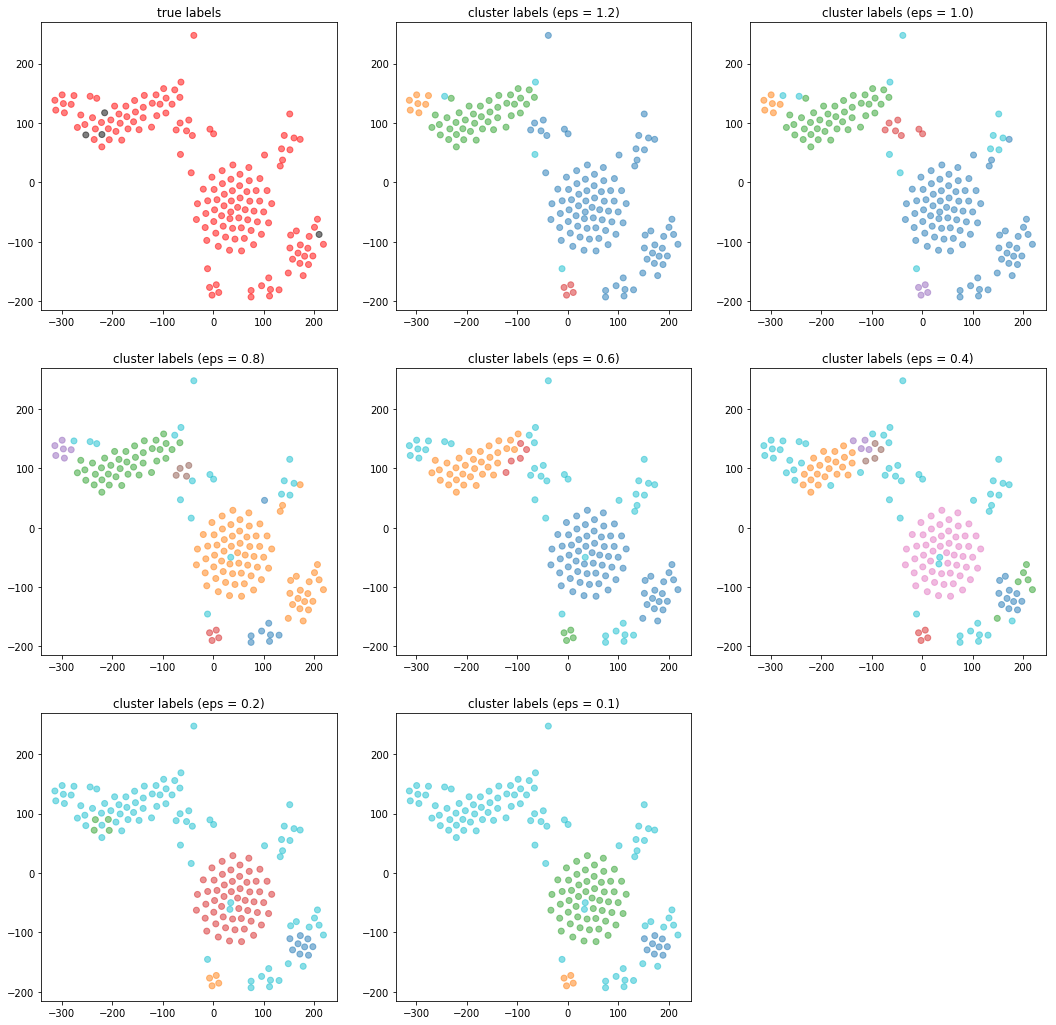

In [26]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=600)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.1 * i for i in range(12, 0, -2)] + [0.1]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [28]:
eps = 0.8

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0
38,b'SDSS J232339.56-031507.7',B,b'1FGL J2323.5-0315 ',b'fsrq ',0
47,b'LLNS 2720',O,b'1FGL J1045.2-5942 ',b'BIN ',0


1 cluster (tab:orange)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
142,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',0


2 cluster (tab:green)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
69,b'[LCL2005b] G305.3+0.2 A2',B0Ve,b' ',b' ',0


3 cluster (tab:red)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
7,b'PG 1101+529',B,b' ',b' ',0
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
30,b'SDSS J020438.26+150820.5',B,b'1FGL J0204.5+1516 ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0
37,b'SDSS J065306.66+281832.1',B,b' ',b'bcu ',0
52,b'GCIRS 8',O,b'1FGL J1745.6-2900c',b'spp ',0


4 cluster (tab:purple)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
5,b'LS VI -04 15',B,b' ',b' ',0
6,b'LS I +56 58',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
19,b'LS IV -14 70',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0


5 cluster (tab:brown)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
9,b'HD 306182',B,b' ',b'spp ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
70,b'CPD-59 3179',B0Ve,b' ',b'spp ',0
83,b'UCAC4 146-087591',B0Ve,b'1FGL J1134.8-6055 ',b'PSR ',0


6 cluster (tab:pink)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
74,b'MAC 1-159',B0Ve,b' ',b'bcu ',0


7 cluster (tab:gray)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0


8 cluster (tab:olive)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
20,b'LS IV -14 72',B,b' ',b' ',0
80,b'2MASS J18444314-0346178',B0Ve,b'1FGL J1844.2-0342c',b' ',0


9 cluster (tab:cyan)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0


-1 cluster (tab:cyan)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
46,b'PG 0042+211',O,b'1FGL J0045.3+2127 ',b'bll ',0
48,b'CPD-58 2614',O,b' ',b' ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
51,b'GCIRS 8',O,b' ',b' ',0
90,b'HD 104705',B0Ve,b' ',b'psr ',0
137,b'2E 4673',B0Ve,b' ',b'snr ',0


* ### cosine distance

In [34]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

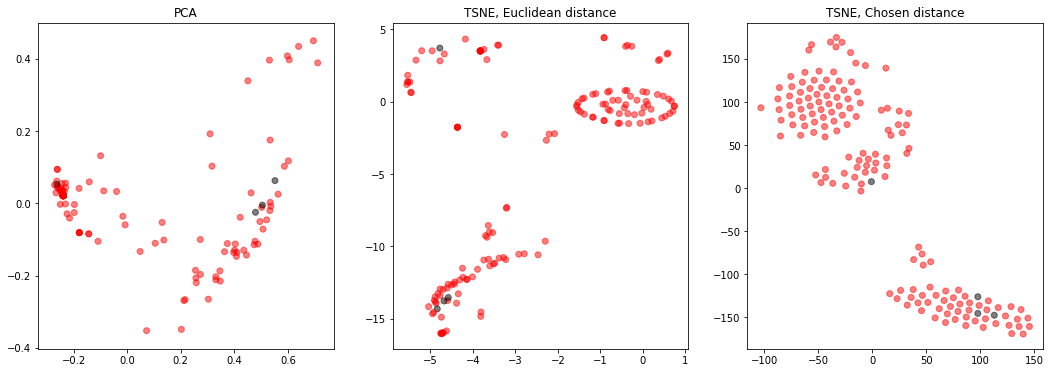

In [35]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=300, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=600)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [36]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.9999998371369465)

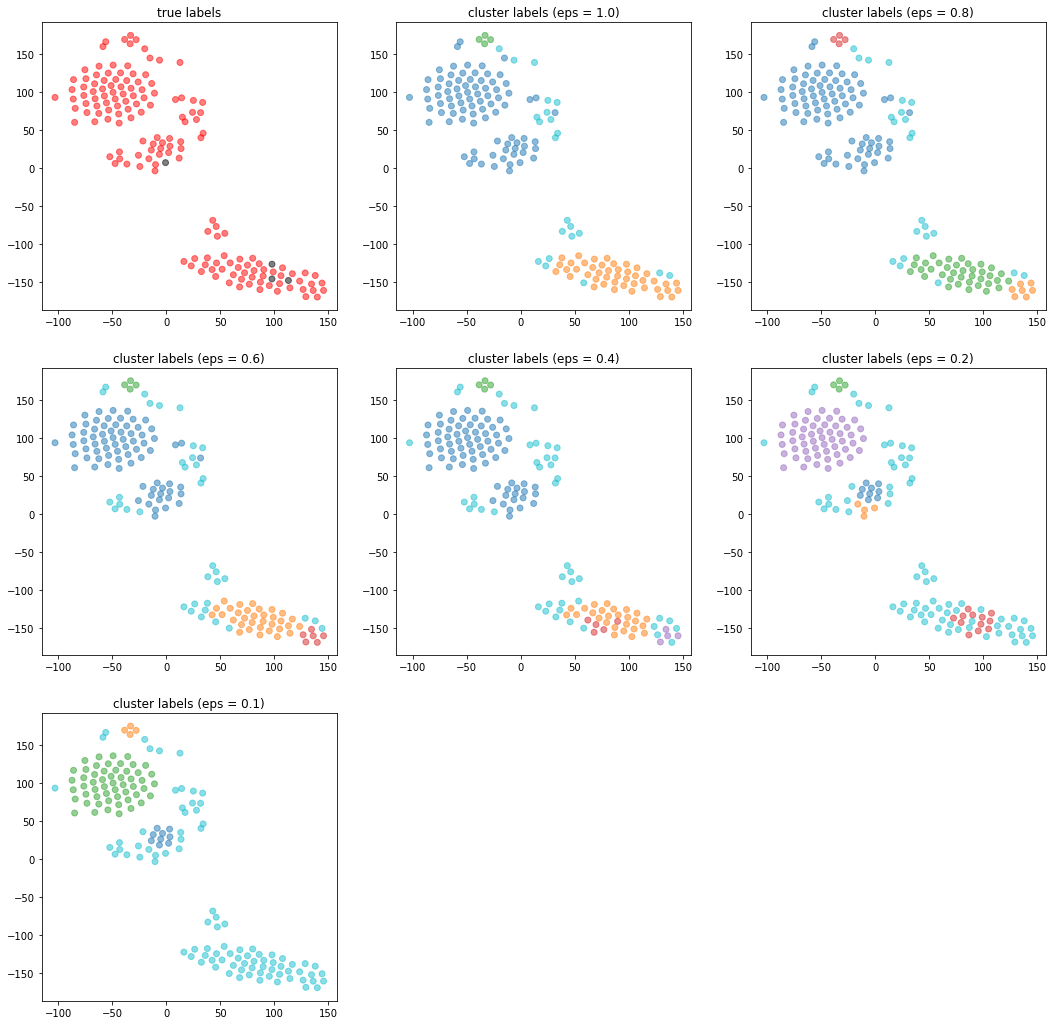

In [37]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=600)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.1 * i for i in range(10, 0, -2)] + [0.1]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [38]:
eps = 0.6

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0
38,b'SDSS J232339.56-031507.7',B,b'1FGL J2323.5-0315 ',b'fsrq ',0
47,b'LLNS 2720',O,b'1FGL J1045.2-5942 ',b'BIN ',0


1 cluster (tab:orange)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
142,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',0


2 cluster (tab:green)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
52,b'GCIRS 8',O,b'1FGL J1745.6-2900c',b'spp ',0


3 cluster (tab:red)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
5,b'LS VI -04 15',B,b' ',b' ',0
6,b'LS I +56 58',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
19,b'LS IV -14 70',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0


4 cluster (tab:purple)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
7,b'PG 1101+529',B,b' ',b' ',0
30,b'SDSS J020438.26+150820.5',B,b'1FGL J0204.5+1516 ',b'bcu ',0
37,b'SDSS J065306.66+281832.1',B,b' ',b'bcu ',0


5 cluster (tab:brown)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
74,b'MAC 1-159',B0Ve,b' ',b'bcu ',0


6 cluster (tab:pink)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0


7 cluster (tab:gray)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
41,b'HD 92406',B,b' ',b' ',0
82,b'HD 306181',B0Ve,b' ',b'spp ',0


8 cluster (tab:olive)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
50,b'[MCF2015] 22',O,b' ',b' ',0
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0


-1 cluster (tab:cyan)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
9,b'HD 306182',B,b' ',b'spp ',0
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
20,b'LS IV -14 72',B,b' ',b' ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
46,b'PG 0042+211',O,b'1FGL J0045.3+2127 ',b'bll ',0
48,b'CPD-58 2614',O,b' ',b' ',0


* ### energy distance

In [39]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

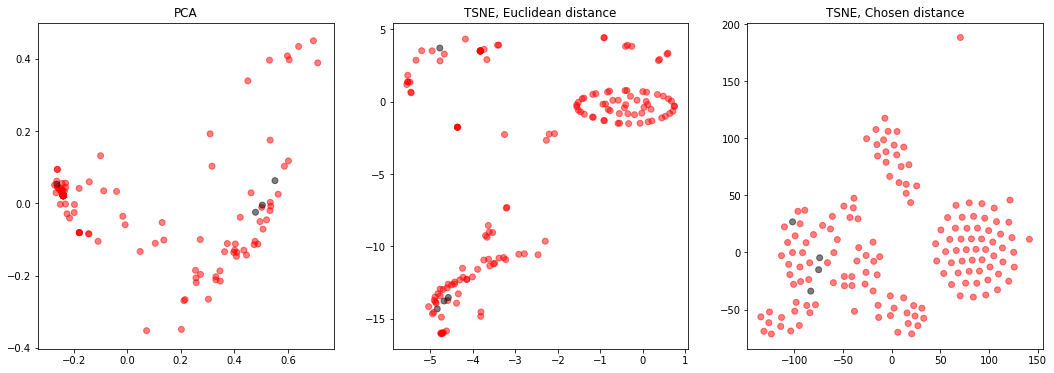

In [40]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=300, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=600)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [41]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.20114301865432688)

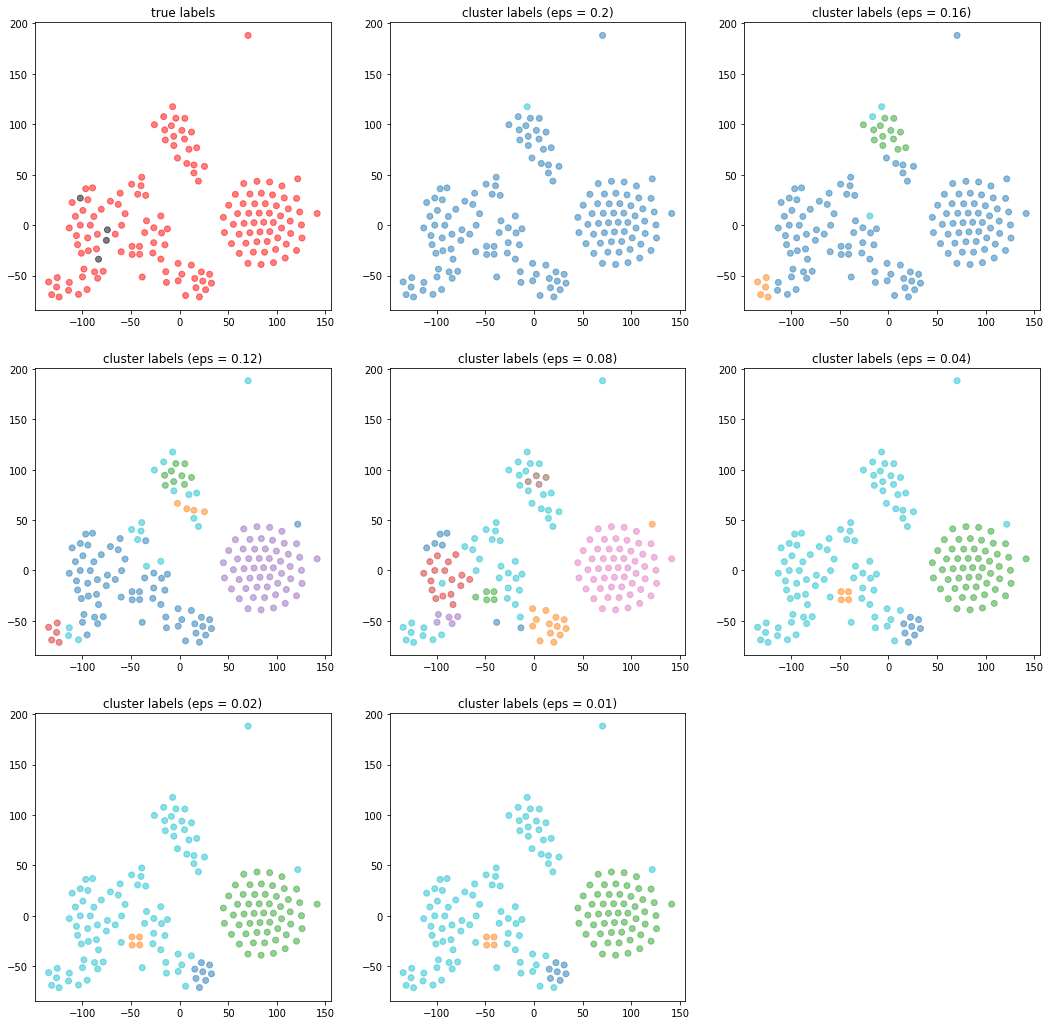

In [43]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=600)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.01 * i for i in range(20, 0, -4)] + [0.02, 0.01]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [44]:
eps = 0.08

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
38,b'SDSS J232339.56-031507.7',B,b'1FGL J2323.5-0315 ',b'fsrq ',0
51,b'GCIRS 8',O,b' ',b' ',0
56,b'BI 23',B0Ve,b' ',b'pwn ',0
122,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',1


1 cluster (tab:orange)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0


2 cluster (tab:green)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
52,b'GCIRS 8',O,b'1FGL J1745.6-2900c',b'spp ',0


3 cluster (tab:red)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
20,b'LS IV -14 72',B,b' ',b' ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0
47,b'LLNS 2720',O,b'1FGL J1045.2-5942 ',b'BIN ',0
54,b'[BKH2005] 16164nr3636',O,b' ',b' ',0
58,b'AzV 236',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
73,b'AzV 216',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
75,b'AzV 233',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0


4 cluster (tab:purple)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
5,b'LS VI -04 15',B,b' ',b' ',0
84,b'CPD-59 2700',B0Ve,b' ',b' ',0


5 cluster (tab:brown)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
6,b'LS I +56 58',B,b' ',b' ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0
42,b'LS III +60 19',B,b' ',b'spp ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
57,b'BD+40 4185',B0Ve,b' ',b' ',0


6 cluster (tab:pink)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
9,b'HD 306182',B,b' ',b'spp ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
61,b'HD 306179',B0Ve,b' ',b'spp ',0
76,b'LS I +62 58',B0Ve,b' ',b' ',0
86,b'V* EN Car',B0Ve,b' ',b'spp ',0


7 cluster (tab:gray)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
10,b'GSC 05698-00468',B,b' ',b'spp ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0
37,b'SDSS J065306.66+281832.1',B,b' ',b'bcu ',0


8 cluster (tab:olive)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
11,b'EM* GGA 394',B,b' ',b'spp ',0
63,b'Cl Trumpler 16 245',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0


9 cluster (tab:cyan)


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
30,b'SDSS J020438.26+150820.5',B,b'1FGL J0204.5+1516 ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
74,b'MAC 1-159',B0Ve,b' ',b'bcu ',0


IndexError: list index out of range